In [1]:
import numpy as np
import h5py
import glob
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
h5_path = 'Datasets/training/data_ppn_larger_train_ratio.h5'
groundtruth_images_path = 'Datasets/training/groundtruth'
satelite_images_path = 'Datasets/training/images'

In [3]:




satelite_images = list(map(Image.open, glob.glob(satelite_images_path + '/*.png')))
groundtruth_images = list(map(Image.open, glob.glob(groundtruth_images_path + '/*.png')))

train_test_ratio = 0.8

train_images = satelite_images[0:int(train_test_ratio*len(satelite_images))]
train_groundtruth = groundtruth_images[0:int(train_test_ratio*len(groundtruth_images))]

test_images = satelite_images[int(train_test_ratio*len(satelite_images)):]
test_groundtruth = groundtruth_images[int(train_test_ratio*len(groundtruth_images)):]

train_shape = (len(train_images), 3, 400, 400)
train_groundtruth_shape = (len(train_images), 1, 400, 400)

test_shape = (len(test_images), 3, 400, 400)
test_groundtruth_shape = (len(test_images), 1, 400, 400)



In [4]:
def add_to_h5(h5file, name_of_group, group, convertion):
    
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert(convertion)
        
        img = np.array(img)
        
        if convertion == 'L':
            
            img = img > 10
            img = img.reshape((400,400,1))
        
        img = np.moveaxis(img, 2, 0) # to tensor
        h5file[name_of_group][i, ...] = img[None]
        
def add_to_h5_normalized(h5file, name_of_group, group, convertion):
    
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert(convertion)
        
        img = np.array(img)
        
        if convertion == 'L':
            
            img = img > 10
            img = img.reshape((400,400,1))
        else:
            # normalize
            img = (img - np.mean(img))/np.std(img)
        
        img = np.moveaxis(img, 2, 0) # to tensor
        h5file[name_of_group][i, ...] = img[None]
        
def add_to_h5_normalized_per_pixel(h5file, name_of_group, group, convertion):
    
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert(convertion)
        
        img = np.array(img)
        
        if convertion == 'L':
            
            img = img > 10
            img = img.reshape((400,400,1))
        else:
            # normalize
            mean = h5file[name_of_group + '_mean'][...]
            std = h5file[name_of_group + '_std'][...]
            img = (img - mean)/std
            
        
        img = np.moveaxis(img, 2, 0) # to tensor
        h5file[name_of_group][i, ...] = img[None]
        
def find_mean_and_std(h5file, means, stds, name_of_group, group):
    # find mean
    mean = np.zeros_like(np.array(group[0].convert('RGB'))).astype(np.float64)
    print()
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert('RGB')
        
        img = np.array(img)
        
        mean = mean + img
        
    mean = mean/len(group)
    
    h5file[means][...] = mean[None]
    
     # find mean
    std = np.zeros_like(np.array(group[0].convert('RGB'))).astype(np.float64)
    
    for i in range(len(group)):
        
        img = group[i]
        img = img.convert('RGB')
        
        img = np.array(img)
        
        std = std + (img - mean)**2
        
    
    std = np.sqrt(std/(len(group) - 1))
    h5file[stds][...] = std[None]
        
    

In [5]:



with h5py.File(h5_path, mode='w') as h5file:
    
    h5file.create_dataset("train", train_shape, np.float64)
    h5file.create_dataset("train_groundtruth", train_groundtruth_shape, np.bool)
    h5file.create_dataset("test", test_shape, np.float64)
    h5file.create_dataset("test_groundtruth", test_groundtruth_shape, np.bool)
    # for per pixel mean + std
    h5file.create_dataset('train_mean', (400, 400, 3), np.float64)
    h5file.create_dataset('train_std',(400, 400, 3), np.float64)
    h5file.create_dataset('test_mean', (400, 400, 3), np.float64)
    h5file.create_dataset('test_std', (400, 400, 3), np.float64)
    
    find_mean_and_std(h5file, 'train_mean', 'train_std', 'train', train_images)
    find_mean_and_std(h5file, 'test_mean', 'test_std', 'test', test_images)
    
    add_to_h5_normalized_per_pixel(h5file, 'train', train_images, 'RGB')
    add_to_h5_normalized_per_pixel(h5file, 'train_groundtruth', train_groundtruth, 'L')
    add_to_h5_normalized_per_pixel(h5file, 'test', test_images, 'RGB')
    add_to_h5_normalized_per_pixel(h5file, 'test_groundtruth', test_groundtruth, 'L')



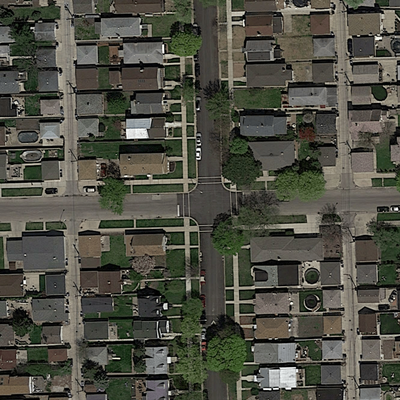

In [6]:
with h5py.File(h5_path, mode='r') as h5file:

    train = h5file['train'][0,...]
    groudtruth = h5file['train_groundtruth'][0,...]
    mean = h5file['train_mean'][...]
    std = h5file['train_std'][...]
    
train = np.moveaxis(train, 0, 2)
groundtruth = np.moveaxis(groudtruth, 0, 2)
train = train*std + mean
train = train.astype("uint8")
groundtruth = groundtruth.astype("uint8")

groundtruth = groundtruth.reshape((400,400))

train = Image.fromarray(train)
groudtruth = Image.fromarray(groundtruth*255)

train





In [7]:
# Get percentage of positives compared to negatives

In [8]:

size_positives = 0
size_total = 0
for i in range(len(groundtruth_images)):
    
    img = groundtruth_images[i]
 
    img = img.convert('L')
    img = np.array(img)
    img = img > 10
    
    size_positives = size_positives + img.sum()
    size_total = size_total + img.shape[0]*img.shape[1]
        
size_positives/size_total

0.2093884375